<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/2022notebooks/2022_0805rnn_comparision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- このファイルは，途中から `~/study/2019keitakurita_Practical_NLP_in_PyTorch.git/deep_dives/lstm_from_scratch.ipynb`
に従っている。

- 注意と BERT については [注意モデルの変遷と展開](https://ShinAsakawa.github.io/2020-0614exawizards_attention.pdf) を参照のこと

---

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/The_LSTM_cell.png/1920px-The_LSTM_cell.png" style="width:49%"><br/>
    wikipedia より
</center>


In [1]:
%config InlineBackend.figure_format = 'retina'
import torch
try:
    import bit
except ImportError:
    !pip install ipynbname --upgrade > /dev/null 2>&1 
    !git clone https://github.com/ShinAsakawa/bit.git
import bit

HOME = bit.HOME
isColab = bit.isColab

日付: 2022-08-05
HOSTNAME: 96e882fc954f
ユーザ名: root
HOME: /root
ファイル名: /fileId=1Gjm4C_pgXPU6lCCtyP8oWNH6vrNb6UmN
torch.__version__: 1.12.0+cu113


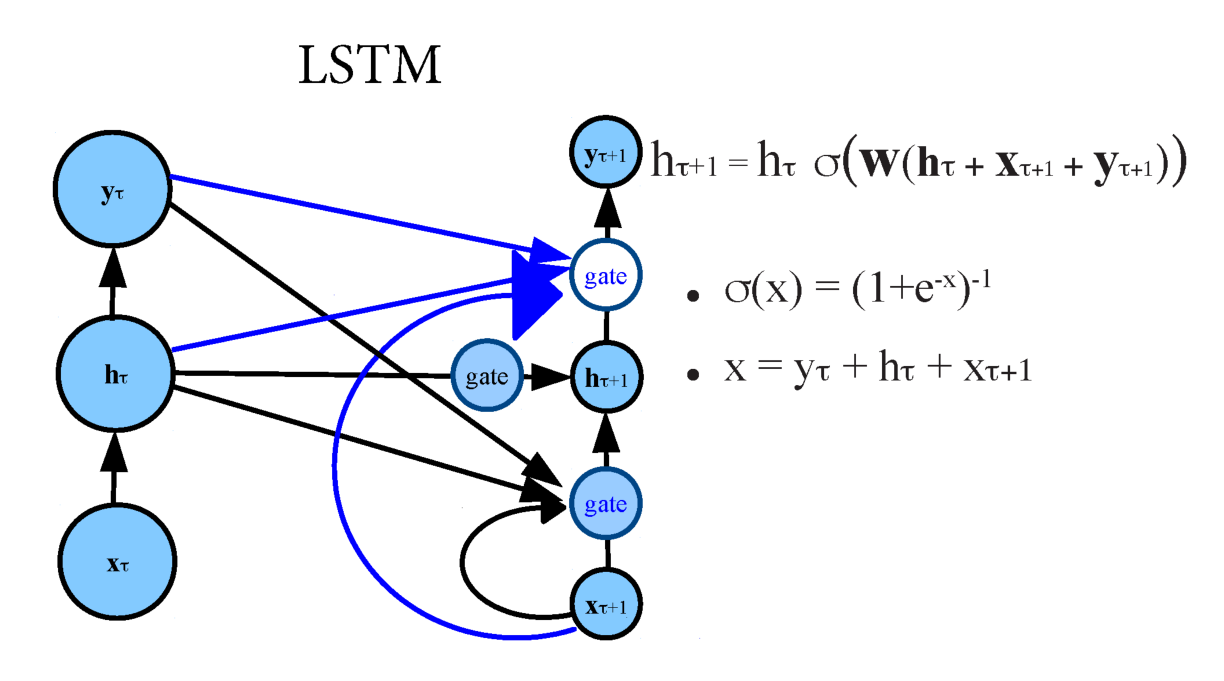

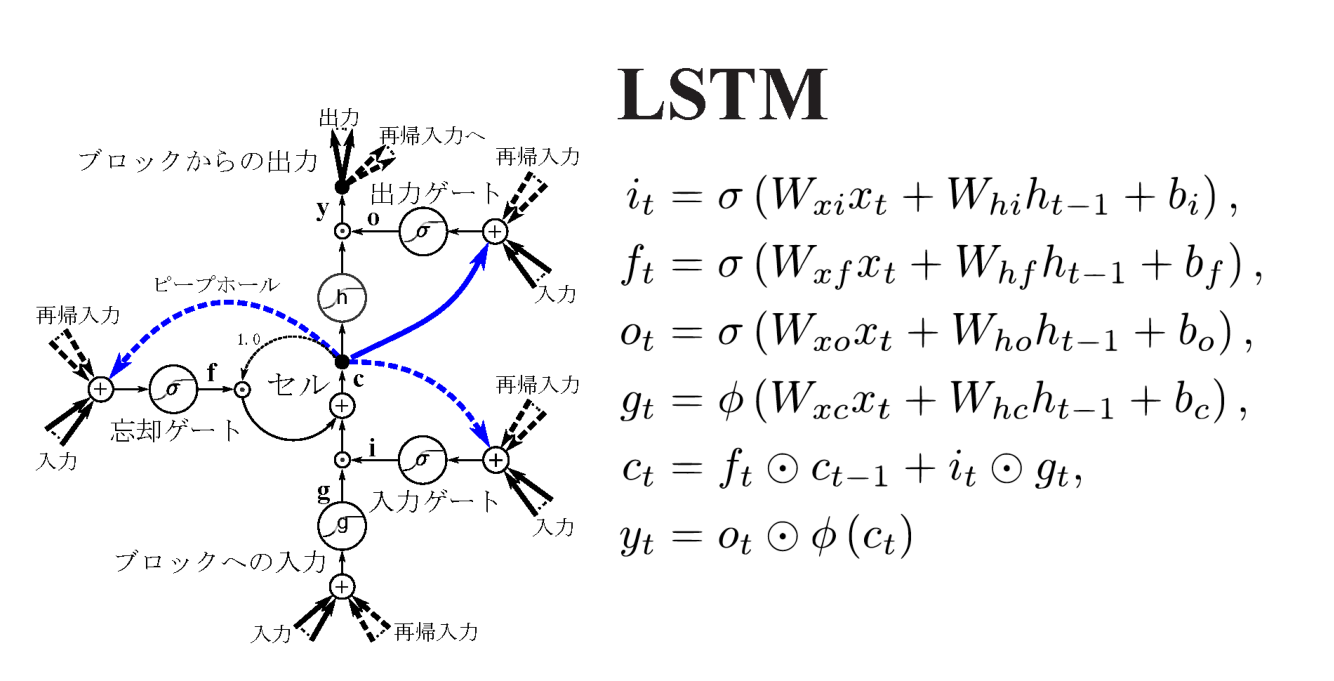

In [2]:
import os
import PIL
import numpy as np
try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib  # matplotlib の日本語表示
%matplotlib inline

img_dir = os.path.join(HOME, 'study/2020project-ccap.github.io.git/')
if os.path.exists(img_dir):
    img1 = plt.imread(os.path.join(img_dir,'2016RNNcamp2LSTM1.png'))
    img2 = plt.imread(os.path.join(img_dir,'2016RNNcamp2LSTM2.png'))
    plt.figure(figsize=(12,6)); plt.axis('off');plt.imshow(img1);plt.show()
    plt.figure(figsize=(12,6)); plt.axis('off');plt.imshow(img2); plt.show()
else:
    import urllib
    for img_fname in ['2016RNNcamp2LSTM1.png', '2016RNNcamp2LSTM2.png']:
        url = 'https://project-ccap.github.io/'+img_fname
        img = np.array(PIL.Image.open(urllib.request.urlopen(url)))
        plt.figure(figsize=(12,6)); plt.axis('off');plt.imshow(img);plt.show()

img_dir = os.path.join(HOME, 'study/2022personal/figures/')
if os.path.exists(img_dir):
    img3 = plt.imread(os.path.join(img_dir,'1920px-The_LSTM_cell.png'))
    plt.figure(figsize=(12,6)); plt.axis('off');plt.imshow(img3);plt.show()

In [3]:
if isColab:
    !pip install --upgrade openpyxl
    !pip install --upgrade pandas
    !pip install --upgrade fugashi[unidic-lite]
    !pip install --upgrade ipadic
    !python -m unidic download
    !pip install transformers
    !pip install --upgrade jaconv
    
# 以下は transformer を使う際に必要となる
# if isColab:
#     !pip install transformers > /dev/null 2>&1 

#     # MeCab, fugashi, ipadic のインストール
#     !apt install aptitude swig > /dev/null 2>&1
#     !aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y > /dev/null 2>&1
#     !pip install mecab-python3 > /dev/null 2>&1
#     !git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git > /dev/null 2>&1
#     !echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a > /dev/null 2>&1
    
#     import subprocess
#     cmd='echo `mecab-config --dicdir`\"/mecab-ipadic-neologd\"'
#     path_neologd = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
#                                      shell=True).communicate()[0]).decode('utf-8')

#     !pip install 'fugashi[unidic]' > /dev/null 2>&1
#     !python -m unidic download > /dev/null 2>&1
#     !pip install ipadic > /dev/null 2>&1
    
#     !pip install konoha

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
download url: https://cotonoha-dic.s3-ap-northeast-1.amazonaws.com/unidic-3.1.0.zip
Dictionary version: 3.1.0+2021-08-31
unidic-3.1.0.zip: 100% 526M/526M [00:33<00:00, 15.7MB/s]
Finished download.
Downloaded UniDic v3.1.0+2021-08-31 to /usr/local/lib/python3.7/dist-packages/unidic/dicdir
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 百人一首 Dataset

In [4]:
import os
import sys
import json
import numpy as np
import time

import jaconv
import requests
from bs4 import BeautifulSoup
from termcolor import colored
from tqdm.notebook import tqdm

import torch
import torch.nn
import torch.utils.data

# リソースの選択（CPU/GPU）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Hyakunin_Isshu(torch.utils.data.Dataset):
    """百人一首のデータを読み込んで PyTorch dataset にする
    上の句と下の句，読み人のデータがある
    """
    def __init__(self, 
                 download:bool=False)->None:
        super().__init__()

        if download: 
            # download=True であれば，データをダウンロードする
            url = 'http://www.diana.dti.ne.jp/~fujikura/List/List.html'
            page = requests.get(url)  # url から内容を取得
            soup = BeautifulSoup(page.content, 'html.parser')
            body = list(soup.children)[0]
            _text = soup.getText().split()[1:-1]
            tankas = {}
            for i in range(len(_text) // 7):
                tankas[i] = {
                    'kami': _text[i * 7 + 2],
                    'simo' :_text[i * 7 + 3],
                    'kami_yomi': _text[i * 7 + 4],
                    'simo_yomi': _text[i * 7 + 5],
                    'yomihito' : _text[i * 7 + 6],
                }
                for x in ['kami','simo','kami_yomi','simo_yomi','yomihito']:
                    tankas[i][x] = jaconv.normalize(tankas[i][x])
        else: 
            # download=False であれば，カレントディレクトリから json ファイルを読み込む
            a = json.load(open('hyakunin_isshu.json'))
            tankas = {int(_a):a[_a] for _a in a} # 辞書のキーを数字に変換

        self.tankas = tankas
            
        # 文字単位の辞書と，かな単位の辞書を作成する。
        # 辞書のインデックス番号を使って，後にワンホット表現を作成するため，辞書が必要
        char_dict, yomi_dict = {}, {} 
        for tanka in tankas:
            kami, simo = tankas[tanka]['kami'], tankas[tanka]['simo']
            kami_yomi, simo_yomi = tankas[tanka]['kami_yomi'], tankas[tanka]['simo_yomi']
            for c in kami+simo:
                if not c in char_dict:
                    char_dict[c] = 1
                else:
                    char_dict[c] += 1
            for c in kami_yomi+simo_yomi:
                if not c in yomi_dict:
                    yomi_dict[c] = 1
                else:
                    yomi_dict[c] += 1

        char_vocab = list(sorted(set(char_dict.keys())))
        yomi_vocab = list(sorted(set(yomi_dict.keys())))
        # 特殊トークンの定義
        self.pad_token = '<PAD>'  # 埋め草トークン 
        self.sos_token = '<SOS>'  # 開始トークン
        self.eos_token = '<EOS>'  # 終末トークン
        self.unk_token = '<UNK>'  # 未定義語，未定義文字トークン
        self.sep_token = '<SEP>'  # 分離トークン
        special_tokens = ['<PAD>', '<SOS>', '<EOS>', '<UNK>', '<SEP>'] 
        self.char_vocab = special_tokens + char_vocab  
        self.yomi_vocab = special_tokens + yomi_vocab
        self.char_vocab_size = len(self.char_vocab)
        self.yomi_vocab_size = len(self.yomi_vocab)
        
        for i in range(len(self.tankas)):
            kami, simo = self.tankas[i]['kami'], self.tankas[i]['simo']
            kami_yomi, simo_yomi = self.tankas[i]['kami_yomi'], self.tankas[i]['simo_yomi']
            self.tankas[i]['kami_ids'] = [self.char_vocab.index(c) for c in kami]
            self.tankas[i]['simo_ids'] = [self.char_vocab.index(c) for c in simo]
            self.tankas[i]['kami_yomi_ids'] = [self.yomi_vocab.index(c) for c in kami_yomi]
            self.tankas[i]['simo_yomi_ids'] = [self.yomi_vocab.index(c) for c in simo_yomi]

    def __len__(self)->int:
        return len(self.tankas)
    
    def __getitem__(self, x:int):
        return self.tankas[x]['kami_ids'] + [self.char_vocab.index(self.sep_token)], self.tankas[x]['simo_ids'] + [self.char_vocab.index(self.eos_token)]

    def line2ids(self, line, vocab=None):
        
        vocab = self.char_vocab if vocab==None else vocab
        ret = []
        for c in line:
            ind = self.char_vocab.index(c) if c in vocab else self.char_vocab.index('<UNK>')
            ret.append(ind)
        return ret

    def ids2chr(self, ids):
        return [self.char_vocab[idx] for idx in ids]
        
    def token2ids(self, tokens:list):
        return [self.char_vocab.index(tkn) for tkn in token]
    
    def ids2tokens(self, ids:list):
        return [self.char_vocab[idx] for idx in ids]

    def yomi_ids2tokens(self, yomi_ids:list):
        return [self.yomi_vocab[idx] for idx in yomi_ids]

dataset = Hyakunin_Isshu(download=True)


In [5]:
import sys
import numpy as np
from termcolor import colored
from tqdm.notebook import tqdm

#from dataset_hyakunin_isshu import Hyakunin_Isshu
#dataset = Hyakunin_Isshu() # download=True)

# サンプル出力，上で定義したデータセットを理解するため
print(colored('文字ボキャ リスト', 'grey', attrs=['bold']), 
      f'char_vocab:{dataset.char_vocab}')
print(colored('読みボキャ リスト', 'grey', attrs=['bold']),
      f'yomi_vocab:{dataset.yomi_vocab}')
print(colored('データ例 dataset.tankas[0]', 'grey', attrs=['bold']), 
      f'{dataset.tankas[0]}')
print(f'ids2tokens:{dataset.ids2tokens(dataset.__getitem__(0)[0])}\n'
      f'ids2tokens:{dataset.ids2tokens(dataset.__getitem__(0)[1])}' )


N = 10
print(f'\nデータの出力 最初の {N} 首')
for num in range(10):
    kami, simo = dataset[num]
    print(colored(f'短歌番号:{num:2d}:', 'grey', attrs=['bold']),
          f'{"".join(dataset.ids2tokens(kami+simo))}')     

# print('# サンプル出力，ランダムサンプリングして出力')
# N=5
# tanka_nums = np.random.permutation(dataset.__len__())[:N]
# for num in tanka_nums:
#     kami, simo = dataset[num]
#     print(colored(f'短歌番号:{num:2d}:', 'grey', attrs=['bold']),
#           f'{"".join(dataset.ids2tokens(kami+simo))}')     


文字ボキャ リスト char_vocab:['<PAD>', '<SOS>', '<EOS>', '<UNK>', '<SEP>', '々', 'あ', 'い', 'う', 'え', 'お', 'か', 'が', 'き', 'ぎ', 'く', 'ぐ', 'け', 'げ', 'こ', 'ご', 'さ', 'ざ', 'し', 'じ', 'す', 'ず', 'せ', 'そ', 'ぞ', 'た', 'だ', 'ち', 'ぢ', 'つ', 'づ', 'て', 'で', 'と', 'ど', 'な', 'に', 'ぬ', 'ね', 'の', 'は', 'ば', 'ひ', 'び', 'ふ', 'ぶ', 'へ', 'べ', 'ほ', 'ぼ', 'ま', 'み', 'む', 'め', 'も', 'や', 'ゆ', 'よ', 'ら', 'り', 'る', 'れ', 'ろ', 'わ', 'ゐ', 'ゑ', 'を', '三', '上', '世', '中', '久', '乙', '九', '乱', '人', '今', '代', '伊', '住', '余', '倉', '光', '入', '八', '具', '冬', '出', '分', '初', '別', '匂', '十', '千', '半', '原', '友', '取', '古', '吉', '同', '名', '向', '君', '吹', '告', '命', '咲', '問', '嘆', '坂', '垣', '堪', '塩', '士', '声', '変', '夏', '夕', '外', '夜', '夢', '大', '天', '奈', '契', '奥', '女', '妙', '姿', '子', '宇', '守', '室', '宵', '宿', '寂', '寄', '富', '寒', '寝', '小', '尽', '尾', '居', '屋', '山', '岩', '岸', '峰', '島', '嵐', '嶺', '川', '巳', '帆', '師', '帰', '常', '幣', '干', '年', '庭', '庵', '弱', '影', '待', '御', '心', '忍', '忘', '思', '恋', '恨', '悲', '惜', '愛', '憂', '手', '打', '折', '摘', '散', '敷', '方', '日', '明'

## PyTorch 公式 LSTM の定義: 
- <https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/rnn.py>


In [6]:
from typing import *
from enum import IntEnum

class Dim(IntEnum):
    batch = 0
    seq = 1
    feature = 2
    
device='cuda' if torch.cuda.is_available() else 'cpu'
#device = torch.device("cuda" if cuda else "cpu")
    
class vanilla_LSTM(torch.nn.Module):
    """Schmithuber らの原著論文に忠実に LSTM を実装。単層の LSTM。ただし `のぞき穴` peephole は未実装"""
    
    def __init__(self, 
                 input_size:int, 
                 hidden_size:int):
        super().__init__()
        
        self.rnn_type = 'vanilla_LSTM'
        self.input_size = input_size
        self.hidden_size = hidden_size

        # 入力ゲートの定義
        self.W_ii = torch.nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hi = torch.nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_i  = torch.nn.Parameter(torch.Tensor(hidden_size))

        # 出力ゲートの定義
        self.W_if = torch.nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hf = torch.nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_f  = torch.nn.Parameter(torch.Tensor(hidden_size))

        # セルの定義 Cell 
        self.W_ig = torch.nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hg = torch.nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_g = torch.nn.Parameter(torch.Tensor(hidden_size))

        # output gate
        self.W_io = torch.nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_ho = torch.nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_o  = torch.nn.Parameter(torch.Tensor(hidden_size))
        
        self.init_weights()
    
    def init_weights(self):
        initrange = 0.1
        
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                #torch.nn.init.xavier_uniform_(p.data)
                torch.nn.init.uniform_(p.data, -initrange, initrange)
            else:
                #torch.nn.init.zeros_(p.data)
                torch.nn.init.uniform_(p.data, -initrange, initrange)
                
        
    def forward(self, 
                inp:torch.Tensor, 
                hid: Optional[Tuple[torch.Tensor, torch.Tensor]]=None,
               ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """系列のマネジメントと埋め込み処理，タイイング処理は言語モデルに任せることにする"""
        
        if hid is None:
            _hid  = torch.zeros(self.hidden_size).to(inp.device)
            _cell = torch.zeros(self.hidden_size).to(inp.device)
        else:
            _hid = hid
            #_hid, _cell = hid
            
        x = inp
        _inputG  = torch.sigmoid(x @ self.W_ii + _hid @ self.W_hi + self.b_i)
        _forgetG = torch.sigmoid(x @ self.W_if + _hid @ self.W_hf + self.b_f)
        _state   = torch.tanh(   x @ self.W_ig + _hid @ self.W_hg + self.b_g)
        _outputG = torch.sigmoid(x @ self.W_io + _hid @ self.W_ho + self.b_o)
        _hid     = _inputG * _state
        _cell    = _forgetG * _cell + _hid
        _out     = _outputG * torch.tanh(_cell)
        #_out = _out.unsqueeze(Dim.batch)
        #out = torch.cat(out, dim=Dim.batch)

        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        #_out = _out.transpose(Dim.batch, Dim.seq).contiguous()
        return _out, (_hid, _cell)


class vanilla_SRN(torch.nn.Module):
    def __init__(self, 
                 input_size: int=0, 
                 hidden_size: int=0,
                ):

        super().__init__()
        self.rnn_type = 'vanilla_SRN'
        self.hidden_size = hidden_size
        self.input_size = input_size
        
        self.W_ih = torch.nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hh = torch.nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.W_ho = torch.nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.bias_h = torch.nn.Parameter(torch.Tensor(hidden_size))
        self.bias_o = torch.nn.Parameter(torch.Tensor(hidden_size))
        
        self.init_weights()

    def init_weights(self):
        torch.nn.init.xavier_uniform_(self.W_ih)
        torch.nn.init.xavier_uniform_(self.W_hh)
        torch.nn.init.xavier_uniform_(self.W_ho)
        torch.nn.init.zeros_(self.bias_h)
        torch.nn.init.zeros_(self.bias_o)
    
    def forward(self, 
                x: torch.Tensor, 
                hid=None) -> torch.Tensor:
        if hid is None:
            _hid = torch.zeros(self.hidden_size).to(x.device)
        else:
            _hid = hid

        _hid = torch.tanh(x @ self.W_ih + _hid @ self.W_hh + self.bias_h)
        _out = torch.tanh(_hid @ self.W_ho + self.bias_o)

        return _out, _hid


In [12]:
# 直上セルで定義した class の引数チェック
num_batch, num_seq, num_feat, num_hid = 3, 10, 32, 16
_data = torch.randn(num_batch, num_seq, num_feat)
lstm = vanilla_LSTM(num_feat, num_hid)
hid_seq, (_, _) = lstm(_data)
print(f'lstm hid_seq.shape:{hid_seq.shape}')

srn = vanilla_SRN(num_feat, num_hid)
hid_seq, _ = srn(_data)
print(f'srn  hid_seq.shape:{hid_seq.shape}')

lstm hid_seq.shape:torch.Size([3, 10, 16])
srn  hid_seq.shape:torch.Size([3, 10, 16])


In [13]:
class naive_RNNLM(torch.nn.Module):
    """上で定義した vanillaLSTM() に被せる ニューラルネットワークのクラス
    入力は，ワンホットベクトルに変換するための トークン ID の系列である
    """
    def __init__(self, 
                 rnn_model:torch.nn.Module = None,
                 n_vocab:int=0,
                 input_size:int=0,
                 hidden_size:int=0,
                 proj_size:int=0):
        super().__init__()
        
        self.model_type = 'naiveRNNLMM'
        self.n_vocab = n_vocab
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.emb_size = input_size
        self.proj_size = n_vocab if proj_size == 0 else proj_size
        self.emb_layer = torch.nn.Embedding(n_vocab, input_size)
        
        if rnn_model == None:  # デフォルトの RNN を vanilla_LSTM とする
            self.rnn_layer = vanilla_LSTM(input_size=input_size, 
                                          hidden_size=hidden_size)
        else:
            self.rnn_layer = rnn_model
            
        self.proj_layer = torch.nn.Linear(in_features=hidden_size, out_features=proj_size)
        self.init_weight()

        
    def init_weight(self):
        initrange = 0.1
        torch.nn.init.uniform_(self.emb_layer.weight, -initrange, initrange)
        torch.nn.init.zeros_(  self.proj_layer.weight)
        torch.nn.init.uniform_(self.proj_layer.weight, -initrange, initrange)

    def forward(self, 
                inp:torch.Tensor, 
                init_state: Optional[Tuple[torch.Tensor, torch.Tensor]]=None,
               ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        
        """入力信号テンソル inp の形状 `(バッチ, 系列，入力信号)` の 3 元テンソルを仮定.
        PyTorch や TensorFlow の慣習。
        おそらく起源は 
        - Karpathy のブログ <https://karpathy.github.io/2015/05/21/rnn-effectiveness/> や 
        - Chris Olah のブログ <https://colah.github.io/posts/2015-08-Understanding-LSTMs/>
        だと思われる"""

        #batch_size, seq_len, n_feature = inp.size()
        seq_len, n_feature = inp.size()
        _out = []
        if init_state is None:
            _hid  = torch.zeros(self.hidden_size).to(inp.device)
            _cell = torch.zeros(self.hidden_size).to(inp.device)
            _hid = (_hid, _cell)
        else:
            _hid = init_state
        _emb = self.emb_layer(inp)
            
        # 系列長，すなわち入力信号の時刻に従って，反復して次時刻の出力を予測するループ
        for t in range(seq_len): 
            x_t = _emb[t, :]  # 時刻 t における入力 $x_t$
            #x_t = _emb[:, t, :]  # 時刻 t における入力 $x_t$
            _hid, _cell = self.rnn_layer(x_t, _hid)
            _out.append(_hid.unsqueeze(Dim.batch))
        _out = torch.cat(_out, dim=Dim.batch)

        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        _out = _out.transpose(Dim.batch, Dim.seq).contiguous()
        _dec = self.proj_layer(_out)
        return torch.nn.functional.log_softmax(_dec, dim=1), _hid

    
    def init_hidden(self, seq_len:int=1):
        weight = next(self.parameters())
        if 'vanilla_LSTM' == self.rnn_layer.rnn_type:
            return (weight.new_zeros(seq_len, self.hidden_size), 
                    weight.new_zeros(seq_len, self.hidden_size))
        elif 'LSTM' == self.rnn_layer.rnn_type:
            return (weight.new_zeros(1, 1, self.hidden_size), 
                    weight.new_zeros(1, 1, self.hidden_size))
        elif 'vanilla_SRN' == self.rnn_layer.rnn_type:
            return weight.new_zeros(seq_len, self.hidden_size)
        elif 'RNN' == self.rnn_layer.rnn_type:
            return weight.new_zeros(1, 1, self.hidden_size)
        else:
            sys.exit(-1)
            

In [14]:
def train_one_epoch(model:torch.nn.Module,
                    data:torch.utils.data.Dataset=Hyakunin_Isshu,
                   )->float:
    
    criterion = torch.nn.CrossEntropyLoss()
    #optimizer = torch.optim.Adam(rnnlm.parameters(), lr=1e-2)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    total_loss = 0.
    model.train()
    shuffled = np.random.permutation(data.__len__())
    for x in shuffled:
        optimizer.zero_grad()
        kami, simo = data[x]
        _inp, _tch = kami[:-1], kami[1:]
        inputs = kami + simo
        _inp, _tch = inputs[:-1], inputs[1:]
        _hid = model.init_hidden(seq_len=len(_inp))
        _hid = torch.tensor(_hid, device=device).view(-1,1)
        
        #print(f'type(_hid):{type(_hid)}')
        #sys.exit()
        _inp = torch.tensor(_inp, dtype=torch.long, device=device).view(-1,1)
        _out, _hid = model(_inp, _hid)
        
        _tch = torch.tensor(_tch, dtype=torch.long, device=device) #.view(-1,1)
        loss = criterion(_out, _tch)
        loss.backward(retain_graph=True)
        #loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss


def evaluate(model:torch.nn.Module,
             num:int=0, 
             data=dataset):
    
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    kami, simo = data[num]
    inputs = kami + simo
    _inp, _tch = inputs[:-1], inputs[1:]
    _hid = model.init_hidden(seq_len=len(_inp))
    _inp = torch.tensor(_inp, dtype=torch.long, device=device).view(-1,1)
    _tch = torch.tensor(_tch, dtype=torch.long, device=device)
    _out, _hid = model(_inp, _hid)
    input_tokens = " ".join(dataset.ids2tokens(inputs))
    print(f'_inp:{"".join(ch for ch in dataset.ids2tokens(inputs))}')
    print(f'_tch:  {"".join(ch for ch in dataset.ids2tokens(_tch.detach().numpy()))}')
    print(f'_out:  {"".join(ch for ch in dataset.ids2tokens(np.argmax(_out.data.detach().numpy(),axis=1)))}')
    
    return total_loss / (len(data) - 1)

In [16]:
%%time
epochs = 300
plt.figure(figsize=(10,6))
for _model in ['vanilla_SRN']:
#for _model in ['vanilla_LSTM', 'vanilla_SRN', 'torch.nn.LSTM', 'torch.nn.RNN']:
    input_size, hidden_size = 32, 32

    rnnlm = naive_RNNLM(
        rnn_model = eval(_model)(input_size=input_size, hidden_size=hidden_size),
        n_vocab = len(dataset.char_vocab), 
        input_size = input_size, 
        hidden_size = hidden_size,
        proj_size = len(dataset.char_vocab),
    )
    
    if _model == 'torch.nn.LSTM':
        rnnlm.rnn_layer.__setattr__('rnn_type', 'LSTM')
    elif _model == 'torch.nn.RNN':
        rnnlm.rnn_layer.__setattr__('rnn_type', 'RNN')
        #rnnlm.rnn_layer.eval()
        #print(rnnlm.rnn_layer.rnn_type)
    print(f'_model: {_model}')
    print(f'rnnlm.eval(): {rnnlm.eval()}')
    
    losses = []
    for _ in tqdm(range(epochs)):
        loss = train_one_epoch(model=rnnlm, data=dataset)
        print(f'損失値={loss:8.3f}       ', end='\r')
        losses.append(loss)
    print(f'最終ステップでの損失値:{loss:.3f}')
    plt.plot(losses, label=_model)
    #plt.title(f'rnnlm, input_size:{input_size}, hidden_size:{hidden_size}')
    #plt.show()

    #print(f'data:{dataset.tankas[9]}')
    print(evaluate(num=9, model=rnnlm))

plt.legend()    
plt.show()    

_model: vanilla_SRN
rnnlm.eval(): naive_RNNLM(
  (emb_layer): Embedding(348, 32)
  (rnn_layer): vanilla_SRN()
  (proj_layer): Linear(in_features=32, out_features=348, bias=True)
)


  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


RuntimeError: ignored

<Figure size 720x432 with 0 Axes>

In [ ]:
lstm = torch.nn.LSTM(input_size=32, hidden_size=32)
print(isinstance(lstm, torch.nn.Module))
print(isinstance(vanilla_LSTM, torch.nn.Module))
print(isinstance(vanilla_SRN, torch.nn.Module))

In [ ]:
#print(dir(lstm))
lstm.__setattr__('rnn_type', 'LSTM')
lstm.rnn_type == 'LSTM'

In [ ]:
%%time
input_size, hidden_size = 32, 32
#rnn_model=vanillaLSTM(input_size=input_size,hidden_size=hidden_size)

rnnlm = RNNLM(
    rnn_model=torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size),
    n_vocab=len(dataset.char_vocab), 
    input_size=input_size, hidden_size=hidden_size,
    n_out=len(dataset.char_vocab),
)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnnlm.parameters(), lr=1e-3)

losses = []
for _ in tqdm(range(200)):
    loss = train_one_epoch(model=rnnlm, data=dataset)
    print(f'損失値={loss:8.3f}       ', end='\r')
    losses.append(loss)
print(f'最終ステップでの損失値:{loss:.3f}')
plt.plot(losses)    
plt.show()
print(rnnlm.eval())
#print(f'data:{dataset.tankas[9]}')
print(evaluate(num=9, model=rnnlm))

#print(f'data:{dataset.tankas[9]}')
print(evaluate(num=9, model=rnnlm))


In [ ]:
import math
#import torch
#import torch.nn as nn
#import torch.nn.functional as F

class RNN_LangModel(torch.nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder.
    sorce: <https://github.com/pytorch/examples/blob/main/word_language_model/model.py>
    """
    def __init__(self, 
                 rnn_type:str='GRU',      # ['LSTM' |'GRU' | 'RNN_TANH' | 'RNN_RELU']
                 n_vocab:int=0,           # 入力に用いる語彙数
                 n_inp:int=0,             # `torch.nn.Embedding()` で RNN 入力層ニューロン数
                 n_hid:int=0,             # RNN 中間層ニューロン数
                 n_layer:int=1,           # RNN 層数
                 dropout:float=0.5,       # ドロップアウト率, RNN の層数が 1 の場合には適用されない
                 tie_weight:bool=False):  # True であれば，入力埋め込み変換の逆変換 (転置行列) が出力の表現

        super().__init__()
        self.n_vocab = n_vocab
        self.dropout = torch.nn.Dropout(p=dropout)
        self.emb_layer = torch.nn.Embedding(n_vocab, n_inp)
        if rnn_type in ['LSTM', 'GRU']:
            self.rnn_layer = getattr(torch.nn, rnn_type)(input_size=n_inp, 
                                                         hidden_size=n_hid, 
                                                         num_layers=n_layer, 
                                                         dropout=dropout, 
                                                         batch_first=True
                                                        )
        else:
            try:
                nonlinearity = {'RNN_TANH': 'tanh', 'RNN_RELU': 'relu'}[rnn_type]
            except KeyError:
                raise ValueError("""規定値以外の引数オプションが rnn_type で指定されました。
                                 設定可能な引数は以下の 4 つです ['LSTM', 'GRU', 'RNN_TANH', 'RNN_RELU']""")
                
            self.rnn_layer = torch.nn.RNN(input_size=n_inp, 
                                          hidden_size=n_hid, 
                                          num_layers=n_layer, 
                                          nonlinearity=nonlinearity, 
                                          dropout=dropout,
                                          batch_first=True,
                                         )
            
        self.out_layer = torch.nn.Linear(n_hid, n_vocab)

        # オプション tie_weights については以下の文献を参照:
        # Using the Output Embedding to Improve Language Models (Press & Wolf 2016, arxiv:1608.05859)
        # Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling (Inan et al. 2016, arxiv:1611.01462)
        if tie_weight:
            if n_hid != n_inp:
                raise ValueError('tie_weight=True` を用いるなら，n_hid と n_inp は等しくする必要があります')
            self.out.weight = self.emb.weight

        self.init_weights()
        self.rnn_type = rnn_type
        self.n_inp = n_inp
        self.n_hid = n_hid
        self.n_layer = n_layer

    def init_weights(self):
        init_range = 0.1
        torch.nn.init.uniform_(self.emb_layer.weight, -init_range, init_range)
        torch.nn.init.zeros_(self.out_layer.weight)
        torch.nn.init.uniform_(self.out_layer.weight, -init_range, init_range)

    def forward(self, inputs, hid):
        _emb = self.dropout(self.emb_layer(inputs))
        _out, _hid = self.rnn_layer(_emb, hid)
        _out = self.dropout(_out)
        _out = self.out_layer(_out)
        _out = _out.view(-1, self.n_vocab)
        return torch.nn.functional.log_softmax(_out, dim=1), hid

    def init_hidden(self, 
                    batch_size:int=1,
                    seq_len:int=1
                  ):
        weight = next(self.parameters())
        if self.rnn_type == 'LSTM':
            #return (weight.new_zeros(batch_size, self.n_layer, self.n_hid),
            #        weight.new_zeros(batch_size, self.n_layer, self.n_hid))
            return (weight.new_zeros(self.n_layer, seq_len, self.n_hid),
                    weight.new_zeros(self.n_layer, seq_len, self.n_hid))
        else:
            return weight.new_zeros(batch_size, seq_len,  self.n_hid)
            #return weight.new_zeros(batch_size, self.n_layer,  self.n_hid)
            #return weight.new_zeros(self.n_layer, batch_size, self.n_hid)
        

In [ ]:
rnnlm = RNN_LangModel(
    #rnn_type = 'GRU',
    rnn_type = 'LSTM',
    #rnn_type = 'RNN_RELU',
    #rnn_type = 'RNN_TANH',
    n_vocab=len(dataset.char_vocab), 
    n_inp=32,
    n_hid=32,
    n_layer=2,
    dropout=0,
    tie_weight=False)
rnnlm.eval()

In [ ]:
%%time
rnnlm = RNN_LangModel(
    #rnn_type = 'GRU',
    #rnn_type = 'LSTM',
    rnn_type = 'RNN_RELU',
    #rnn_type = 'RNN_TANH',
    n_vocab=len(dataset.char_vocab), 
    n_inp=64,
    n_hid=64,
    n_layer=2,
    dropout=0.1,
    tie_weight=False)

criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(rnnlm.parameters(), lr=1e-2)
optimizer = torch.optim.Adam(rnnlm.parameters(), lr=1e-3)

losses = []
#for _ in tqdm(range(3)):
for _ in tqdm(range(300)):
    loss = train_one_epoch(model=rnnlm, data=dataset)
    print(f'損失値={loss:8.3f}       ', end='\r')
    losses.append(loss)
print(f'最終ステップでの損失値:{loss:.3f}')
plt.plot(losses)    
plt.show()
print(rnnlm.eval())

#print(f'data:{dataset.tankas[9]}')
print(evaluate(num=9, model=rnnlm))


In [ ]:
# Temporarily leave PositionalEncoding module here. Will be moved somewhere else.
class PositionalEncoding(torch.nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, 
                 d_model, 
                 dropout:float=0.1, 
                 max_len:int=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

    
class TransformerModel(torch.nn.Module):
    """Container module with an encoder, a recurrent or transformer module, and a decoder."""

    def __init__(self, 
                 ntoken:int=0, 
                 ninp:int=0, 
                 nhead:int=0, 
                 nhid:int=0, 
                 nlayers:int=1, 
                 dropout=0.5):
        super().__init__()
        try:
            from torch.nn import TransformerEncoder, TransformerEncoderLayer
        except:
            raise ImportError('TransformerEncoder module does not exist in PyTorch 1.1 or lower.')
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.weight)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, src, has_mask=True):
        if has_mask:
            device = src.device
            if self.src_mask is None or self.src_mask.size(0) != len(src):
                mask = self._generate_square_subsequent_mask(len(src)).to(device)
                self.src_mask = mask
        else:
            self.src_mask = None

        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return F.log_softmax(output, dim=-1)

In [ ]:
%%time
rnnlm = RNNModel(
    rnn_type = 'RNN_TANH',
    n_vocab=len(dataset.char_vocab), 
    n_inp=32,
    n_hid=32,
    n_layer=1,
    #n_out=len(dataset.char_vocab),
    dropout=0,
    tie_weight=False)

criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(rnnlm.parameters(), lr=1e-2)
optimizer = torch.optim.Adam(rnnlm.parameters(), lr=1e-3)

losses = []
for _ in tqdm(range(300)):
    loss = train_one_epoch(model=rnnlm, data=dataset)
    print(f'損失値={loss:8.3f}       ', end='\r')
    losses.append(loss)
print(f'最終ステップでの損失値:{loss:.3f}')
plt.plot(losses)    
plt.show()
print(rnnlm.eval())

#print(f'data:{dataset.tankas[9]}')
print(evaluate(num=9, model=rnnlm))


`class Module(builtins.object)`: 全ニューラルネットワークモジュールの礎となるクラス
PyTorch で定義するモデルは全て，このクラスの下位クラスである必要がある。
このモジュールには，他のモジュールを取り込んで，入れ子にしたり，木構造にしたりすることが可能。  
下位モジュールは通常の属性として割り当てることができる

```python  
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))
```

ここでポイントとなるのは，入力次元が 3 元テンソルであることである。
3 元とは，['バッチサイズ'，'系列長'，'特徴数'] である。
これは，入力文に即して言えば，['入力文の数','文の長さ(の最大値)','語彙の数'] ということになる。
第 1 次元は，複数の文をまとめて処理するための次元である。
各入力文の長さが異なると，テンソルとして扱えないので，すべての入力文の長さを揃える必要がある。
そのため，第 2 次元の '文の長さ' が必要な情報となる。BERT では 512 で切断している。
バッチ単位で揃っている必要がある。そのために，特殊トークンである 'PAD' が用いられる。
第 3 次元の '単語数' は，RNN の入力層のニューロン数である。
ここで，埋め込み `torch.nn.Embedding()` という Pytorch に用意されている関数を紹介する。
この関数 `torch.nn.Embedding()` は任意のベクトルを受けとり，それを実数ベクトルへと変換する。
具体的な宣言は，以下の通りである:

```python
Embedding(num_embeddings: int, embedding_dim: int, 
          padding_idx: Optional[int] = None, 
          max_norm: Optional[float] = None, 
          norm_type: float = 2.0, 
          scale_grad_by_freq: bool = False, 
          sparse: bool = False, 
          _weight: Optional[torch.Tensor] = None, 
          device=None, 
          dtype=None) -> None
```

`torch.nn.Embedding()` は，第 1 引数の次元のワンホットベクトルを，第 2 引数次元の実ベクトルへの変換する。
すなわち，

* 第 1 引数 num_embeddings (int): 埋め込み辞書のサイズ
* 第 2 引数 embedding_dim (int): 埋め込みベクトルのサイズ
* `padding_idx` (int, optional): 指定されていれば，勾配計算に無関係な埋め込みトークンを指定する。
この引数が指定されていれば，訓練中に更新されない。PyTorch では 0 番目のインデックス番号が，このパディングに使用される。
具体的には，実数 0.0 を割り当てれば，どのような勾配更新値が与えられようが，値は更新されない。そのような実装がなされているものと想定される。
* `max_norm` (float, optional): この引数が指定されると，この `max_norm` よりも大きなノルムを持つ各埋め込みベクトルは， `max_norm` のノルムになるように再正規化される。
* `norm_type` (float, optional): `max_norm` を算出する際に用いられる，p-norm の p を指定する。デフォルトは 2 
* `scale_grad_by_freq` (boolean, optional): 与えられた場合、これはミニバッチ内の単語の頻度の逆数で勾配をスケーリングする。デフォルトは `偽` である。頻度に応じたスケーリングを行えば，低頻度出現項目ほど有利になる。低頻度項目の学習が遅いという問題を解決するためであると思われる。
* `sparse` (bool, optional): `True` の場合， `weight` 行列に対する勾配は，疎テンソルとなる。

```bash
>>> # an Embedding module containing 10 tensors of size 3
>>> embedding = nn.Embedding(10, 3)
>>> # a batch of 2 samples of 4 indices each
>>> input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
>>> embedding(input)
    tensor([[[-0.0251, -1.6902,  0.7172],
             [-0.6431,  0.0748,  0.6969],
             [ 1.4970,  1.3448, -0.9685],
             [-0.3677, -2.7265, -0.1685]],

             [[ 1.4970,  1.3448, -0.9685],
              [ 0.4362, -0.4004,  0.9400],
              [-0.6431,  0.0748,  0.6969],
              [ 0.9124, -2.3616,  1.1151]]])
```

従って，ある単語なり，文字なり，項目なりが入力される場合には，これをワンホット表現へと変換する必要がある。
このときに用いられる関数が以下のような関数である。

```
def convert_ids2tensor(sentence_ids):
    """数値 ID リストをテンソルに変換
    例えば，[0,1,2] -> tensor([[0],[1],[2]])"""
    return torch.tensor(sentence_ids, dtype=torch.long, device=device).view(-1, 1)
```